# Case Study: Monitoring and failure prediction of health monitoring device

September 2022 <br>
Fatih Catpinar

For clinical trials, in order to reduce the cost, remote health monitoring devices are used to monitor patients’ parameters at homes. However, verifying if measurements of devices are not impacted by their technical fault is a challenging problem.  

The task is to build a model to predict device failure given the daily aggregated device telemetry readings.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PowerTransformer


## Table of Contents
1. Explore and clean the data
2. Data transformations and Feature Engineering¶
3. Create the model
4. Conclusion

## 1. Explore and clean the data

The first step is loading the data and exploring. Before we doing analyses and creating classification models, we need to understand the data and make sure there is no incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset.



### Initial inspection

There are 124,494 rows and 12 columns. In each row, we have the device number, date, failure status, and 9 sensor readings.

In [2]:
df = pd.read_csv('Case_1_Data_device_failure.csv')

In [3]:
df.shape

(124494, 12)

In [4]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
# Check number of unique devices
df['device'].nunique()

1169

There are 1169 unique devices in the data.

### Check the dates

The data is from 2015-01-01 and 2015-11-02. There are 305 days in between, We have 1169 unique devices. We had 124,494 readings in the data. It means we don't have daily readings for every device.

In [6]:
# Convert dates to datetime
df['date'] = pd.to_datetime(df['date'])

print(df['date'].min())
print(df['date'].max())

2015-01-01 00:00:00
2015-11-02 00:00:00


In [7]:
# Number of days between the frist date and the last date
(df['date'].max() - df['date'].min()).days

305

In [8]:
1169*305

356545

In [9]:
# Number of different days in the data
df.groupby(['date']).agg(['count']).shape

(304, 11)

There are 304 unique dates.

In [10]:
# Number of readings for each device
df['device'].value_counts()

S1F0FP0C    304
W1F05X69    304
Z1F0QK05    304
S1F0GCED    304
W1F0SJJ2    304
           ... 
Z1F0LT6Z      5
Z1F11RAE      5
S1F04KSC      4
W1F0WJFT      3
W1F1DA5�      1
Name: device, Length: 1169, dtype: int64

In [11]:
# Stats of readings count
df['device'].value_counts().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: device, dtype: float64

This shows how many readings each device has. The maximum reading cound is 304. The mean is 106.

In [12]:
# Check if there is any device that has two measurement in a day.
df.duplicated(subset=['date', 'device']).sum()

1

In [13]:
df[df.duplicated(subset=['date', 'device']) == True]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
101335,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0


There is one device that has 2 readings in the same day. Need to investigate, it might be a duplicate.

### Handle the duplicates

In [14]:
# Check any duplicates
df.duplicated().sum()

1

There is one duplicated row.

In [15]:
# Find the duplicated rows
df_temp = df[df.duplicated()]
df[(df['date']==df_temp['date'].iloc[0]) & (df['device']==df_temp['device'].iloc[0])]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
101334,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0
101335,2015-07-10,S1F0R4Q8,0,192721392,0,0,0,8,213700,0,0,0


In [16]:
# Drop the duplicates
df = df.drop_duplicates()

In [17]:
df.duplicated().sum()

0

### Check for missing values

In [18]:
df.isnull().sum(axis = 0)

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

It seems there is no missing value. We don't have to do anything. I also want to check how many zeros we have in the data.

In [19]:
# Get the count of Zeros in each attribute column
for column in df.columns:
    count = (df[column] == 0).sum()
    print('Count of zeros in '+ column+ ' : ', count)

Count of zeros in date :  0
Count of zeros in device :  0
Count of zeros in failure :  124387
Count of zeros in attribute1 :  11
Count of zeros in attribute2 :  118109
Count of zeros in attribute3 :  115358
Count of zeros in attribute4 :  115155
Count of zeros in attribute5 :  0
Count of zeros in attribute6 :  0
Count of zeros in attribute7 :  123035
Count of zeros in attribute8 :  123035
Count of zeros in attribute9 :  97357


We had 124,494 readings in total. Attributes 2,3,4,7,8 have zores more than ~115000. More that %92 of the mentioned featues are zero. It might be possible since these are the sensor data. But, attribute7 and attribute8 has the same amount of zeros. Need to investigate, they might be duplicated columns.

### Check for duplicated columns

In [20]:
# Check duplicated columns
df.T.duplicated()

date          False
device        False
failure       False
attribute1    False
attribute2    False
attribute3    False
attribute4    False
attribute5    False
attribute6    False
attribute7    False
attribute8     True
attribute9    False
dtype: bool

There is one duplicateed column.

In [21]:
(df['attribute7'] == df['attribute8']).all()

True

'attribute7' and 'attribute8' identical. We can drop 'attribute8'.

In [22]:
df = df.drop('attribute8', axis=1)

In [23]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


### Failure stats

There are 124388 no failures and 106 failures. 0.085% failure rate. This data set is very unbalanced. Before applying any machine learning algoritm, we need to come with an idea to mitigate the impact of a small number of observed failures.

In [24]:
df.groupby(['failure'])['device'].agg('count')

failure
0    124387
1       106
Name: device, dtype: int64

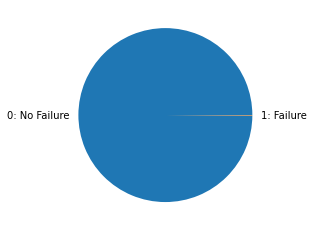

In [25]:
y = df['failure'].value_counts()
mylabels = ["0: No Failure", "1: Failure"]

plt.pie(y, labels = mylabels)
plt.show() 

In [26]:
# For each device, count the failure and no failure cases
df_temp = df.groupby('device')['failure'].agg('sum').sort_values(ascending=False).reset_index()
df_temp.head()

,device,failure
0,Z1F0LSNZ,1
1,W1F1230J,1
2,Z1F0P5D9,1
3,S1F0L0DW,1
4,W1F1DQN8,1


In [27]:
# Is there any device that has more than 1 failure?
df_temp[df_temp['failure'] > 1].shape[0]

0

There are total 106 failure cases and all the failures are for unique devices. Want to check if the failure is in different dates?

In [28]:
df_failure = df[df['failure'] == 1]
df_failure_count = df_failure.groupby('date')['device'].agg(['unique', 'count']).reset_index()
df_failure_count[df_failure_count['count']>1].sort_values(by="count", ascending=False)

,date,unique,count
7,2015-01-19,"[S1F023H2, S1F0QY11, S1F0S2WJ, W1F0Z1W9, W1F15...",8
16,2015-02-04,"[W1F0TA59, Z1F0LVGY, Z1F0MCCA]",3
43,2015-05-08,"[S1F0RR35, Z1F1653X, Z1F1AG5N]",3
15,2015-02-02,"[W1F0SGHR, W1F0VDH2]",2
46,2015-05-13,"[S1F0GKL6, Z1F0K451]",2
65,2015-07-20,"[S1F0LD15, W1F1BFP5]",2
64,2015-07-18,"[S1F09DZQ, W1F11ZG9]",2
61,2015-07-12,"[S1F0GPFZ, S1F0J5JH]",2
59,2015-07-09,"[S1F0S65X, W1F1BS0H]",2
51,2015-05-28,"[S1F0GSD9, S1F0QF3R]",2


There is a day 8 devices are failed. There are some days 2 devices are failed. We can use this information to pair the devices that fail together. 

### Failure per month

In [29]:
# Create a column for month and year
df['Month_Year'] = df["date"].apply(lambda x: x.strftime("%B %Y"))

We will check the number of data per month and failur per month

In [30]:
# Group the months
df_month = df.groupby('Month_Year').agg({'date':'max', 
                                         'failure':'sum', 
                                         'device':'count'}).reset_index()
df_month = df_month.sort_values(by='date', ascending=True).reset_index(drop=True)
df_month

,Month_Year,date,failure,device
0,January 2015,2015-01-31,24,25032
1,February 2015,2015-02-28,14,19500
2,March 2015,2015-03-31,9,19833
3,April 2015,2015-04-30,9,12012
4,May 2015,2015-05-31,21,11330
5,June 2015,2015-06-30,6,10469
6,July 2015,2015-07-31,16,10530
7,August 2015,2015-08-31,4,8346
8,September 2015,2015-09-30,0,4470
9,October 2015,2015-10-31,3,2940


In [31]:
df_month.columns = ['Month_Year', 'date', 'failure_count', 'reading_count']
df_month

,Month_Year,date,failure_count,reading_count
0,January 2015,2015-01-31,24,25032
1,February 2015,2015-02-28,14,19500
2,March 2015,2015-03-31,9,19833
3,April 2015,2015-04-30,9,12012
4,May 2015,2015-05-31,21,11330
5,June 2015,2015-06-30,6,10469
6,July 2015,2015-07-31,16,10530
7,August 2015,2015-08-31,4,8346
8,September 2015,2015-09-30,0,4470
9,October 2015,2015-10-31,3,2940


In [32]:
df_month['fail_rate'] = (df_month['failure_count'] / df_month['reading_count'])*100
df_month

,Month_Year,date,failure_count,reading_count,fail_rate
0,January 2015,2015-01-31,24,25032,0.095877
1,February 2015,2015-02-28,14,19500,0.071795
2,March 2015,2015-03-31,9,19833,0.045379
3,April 2015,2015-04-30,9,12012,0.074925
4,May 2015,2015-05-31,21,11330,0.185349
5,June 2015,2015-06-30,6,10469,0.057312
6,July 2015,2015-07-31,16,10530,0.151947
7,August 2015,2015-08-31,4,8346,0.047927
8,September 2015,2015-09-30,0,4470,0.000000
9,October 2015,2015-10-31,3,2940,0.102041


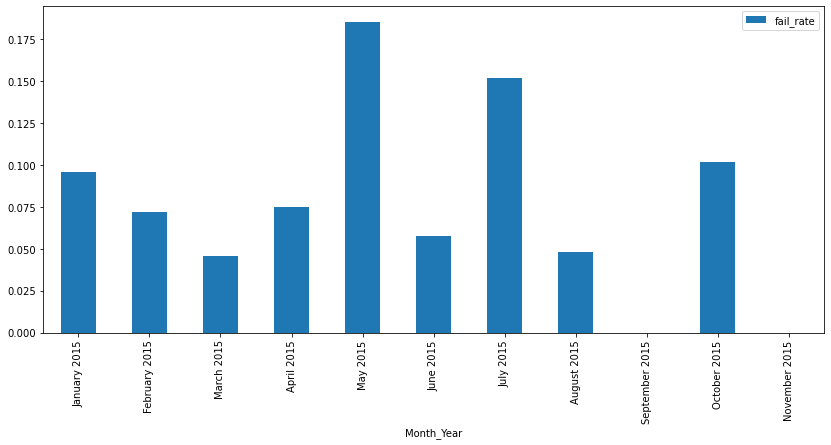

In [33]:
ax = df_month.plot.bar(x='Month_Year', y='fail_rate', figsize=(14, 6), rot=90)

We can use this information as a feature for our classification model. I will add the feature to the data in the next section.

### Box and whisker plot for each feature

Box and whisker plot for each feature


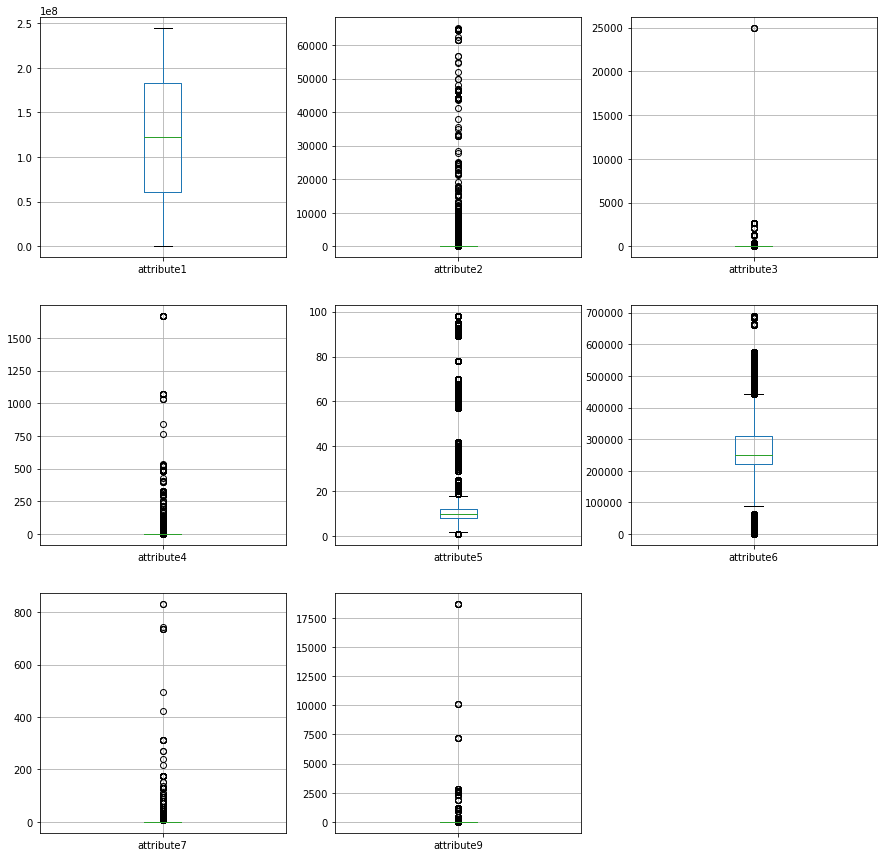

In [34]:
print("Box and whisker plot for each feature")

fig = plt.figure(figsize = (15, 15))
plt.subplot(3,3,1)
df.boxplot(column=['attribute1']) 
plt.subplot(3,3,2)
df.boxplot(column=['attribute2'])
plt.subplot(3,3,3)
df.boxplot(column=['attribute3']) 
plt.subplot(3,3,4)
df.boxplot(column=['attribute4'])
plt.subplot(3,3,5)
df.boxplot(column=['attribute5']) 
plt.subplot(3,3,6)
df.boxplot(column=['attribute6'])
plt.subplot(3,3,7)
df.boxplot(column=['attribute7']) 
plt.subplot(3,3,8)
df.boxplot(column=['attribute9']) 
plt.show()

We have already know that most of the Attributes 2,3,4,7 have zores. All of the attributes other than 'Attribute1' is skewed. Skewness is asymmetry in a statistical distribution, in which the curve appears distorted or skewed either to the left or to the right. We need to handle this before we feed our data into the learning algoritm.

In [35]:
df.skew()

failure       34.227056
attribute1    -0.011127
attribute2    23.857827
attribute3    82.711947
attribute4    41.502446
attribute5     3.483663
attribute6    -0.375295
attribute7    73.476162
attribute9    49.899079
dtype: float64

In [36]:
# Generate descriptive statistics
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
count,124493.000000,1.244930e+05,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000,124493.000000
mean,0.000851,1.223875e+08,159.486043,9.940535,1.741134,14.222719,260173.031022,0.292531,12.451624
std,0.029167,7.045934e+07,2179.666438,185.748065,22.908598,15.943082,99151.389285,7.436954,191.426389
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000
25%,0.000000,6.128346e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000
50%,0.000000,1.227971e+08,0.000000,0.000000,0.000000,10.000000,249800.000000,0.000000,0.000000
75%,0.000000,1.833091e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,18701.000000


### Check the corrolation 

Examine a simple correlation of the independent variable with the dependent variable.

In [37]:
df_corr = df.corr(method='pearson')

In [38]:
abs(df_corr[['failure']]).sort_values(by='failure', ascending=False)

,failure
failure,1.000000
attribute7,0.119055
attribute4,0.067398
attribute2,0.052902
attribute5,0.002270
attribute1,0.001984
attribute9,0.001622
attribute3,0.000948
attribute6,0.000550


Correlation coefficients are used to measure the strength of the linear relationship between two variables. Here we checked the corration between dependent and independent variable. attribute7 and attribute8 has 0.11 corralation. The hisger is the better.

## 2. Data transformations and feature engineering

We can transform our data for a machine learning model to more relaible results. We can add an additional feature that shows the staus before the failure accur.

- Add min, max, and mean values for each feature of each device.
- Add failure rate per month info that we calculated before.


Also, the last reading or readings before the failure might give us some information. We migth consider extracting a features from that as well. 

### Create min, max, and mean features for each column

In [39]:
faeture_list = ['attribute1', 'attribute2', 'attribute3', 'attribute4',
                'attribute5', 'attribute6', 'attribute7', 'attribute9']

In [40]:
for feature in faeture_list:
    
    new_feature_min = feature + '_min'
    new_feature_max = feature + '_max'
    new_feature_mean = feature + '_mean'
    
    df[new_feature_min] = df.groupby('device')[feature].transform('min')
    df[new_feature_max] = df.groupby('device')[feature].transform('max')
    df[new_feature_mean] = df.groupby('device')[feature].transform('mean')

In [41]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute5_mean,attribute6_min,attribute6_max,attribute6_mean,attribute7_min,attribute7_max,attribute7_mean,attribute9_min,attribute9_max,attribute9_mean
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,...,6.000000,407438,409404,407878.500000,0,0,0.0,7,7,7.0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,...,6.000000,403174,404786,403549.166667,0,0,0.0,0,0,0.0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,...,12.000000,237394,259491,254926.604167,0,0,0.0,0,0,0.0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,...,6.000000,410186,412151,410630.833333,0,0,0.0,0,0,0.0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,...,17.349776,313173,344875,331206.524664,0,0,0.0,3,3,3.0


### Add failure rate per month info as a feature

We had fail rate per month information. We will merge this data to our main dataframe.

In [42]:
df_month.head()

,Month_Year,date,failure_count,reading_count,fail_rate
0,January 2015,2015-01-31,24,25032,0.095877
1,February 2015,2015-02-28,14,19500,0.071795
2,March 2015,2015-03-31,9,19833,0.045379
3,April 2015,2015-04-30,9,12012,0.074925
4,May 2015,2015-05-31,21,11330,0.185349


In [43]:
df_month.shape

(11, 5)

In [44]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'Month_Year', 'attribute1_min', 'attribute1_max', 'attribute1_mean',
       'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute3_min',
       'attribute3_max', 'attribute3_mean', 'attribute4_min', 'attribute4_max',
       'attribute4_mean', 'attribute5_min', 'attribute5_max',
       'attribute5_mean', 'attribute6_min', 'attribute6_max',
       'attribute6_mean', 'attribute7_min', 'attribute7_max',
       'attribute7_mean', 'attribute9_min', 'attribute9_max',
       'attribute9_mean'],
      dtype='object')

In [45]:
df.shape

(124493, 36)

In [46]:
# Merge data on Month_Year
df_merged = df.merge(df_month[['Month_Year', 'fail_rate']], how='left', on='Month_Year')
df_merged.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'Month_Year', 'attribute1_min', 'attribute1_max', 'attribute1_mean',
       'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute3_min',
       'attribute3_max', 'attribute3_mean', 'attribute4_min', 'attribute4_max',
       'attribute4_mean', 'attribute5_min', 'attribute5_max',
       'attribute5_mean', 'attribute6_min', 'attribute6_max',
       'attribute6_mean', 'attribute7_min', 'attribute7_max',
       'attribute7_mean', 'attribute9_min', 'attribute9_max',
       'attribute9_mean', 'fail_rate'],
      dtype='object')

### The last readings before fail feature

The failure might give some indication even if it not broken before the failure. The last reading before the failure mogh give us some information. I have not created a feature from this information. This section is added as future work.

In [47]:
df_test = df[['date','device','failure']]
df_test[df_test['device']=='S1F0RRB1']

,date,device,failure
235,2015-01-01,S1F0RRB1,0
1398,2015-01-02,S1F0RRB1,0
2561,2015-01-03,S1F0RRB1,0
3724,2015-01-04,S1F0RRB1,0
4885,2015-01-05,S1F0RRB1,1


### Prepare the data for the machine learning model

We neeed to drop the date and month_year column. Before deleteiong the date, I would like to create a seperate year, month and day column.

In [48]:
df.columns

Index(['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'Month_Year', 'attribute1_min', 'attribute1_max', 'attribute1_mean',
       'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute3_min',
       'attribute3_max', 'attribute3_mean', 'attribute4_min', 'attribute4_max',
       'attribute4_mean', 'attribute5_min', 'attribute5_max',
       'attribute5_mean', 'attribute6_min', 'attribute6_max',
       'attribute6_mean', 'attribute7_min', 'attribute7_max',
       'attribute7_mean', 'attribute9_min', 'attribute9_max',
       'attribute9_mean'],
      dtype='object')

In [49]:
df['month'] = df["date"].apply(lambda x: x.month)
df['day'] = df["date"].apply(lambda x: x.day)

In [50]:
# dropping date and Month_Year column
df = df.drop(columns=['date', 'Month_Year'])

## 3. Preprocessing

Define the features and the true label column.

In [51]:
# Randomizes the data
df_randomized = df.sample(frac=1, random_state=0).reset_index(drop=True)

In [52]:
df_x = df_randomized.drop(columns=['failure','device'])
df_y = df_randomized['failure']

### Handle the skewness

In [53]:
df_x.skew()

attribute1          -0.011127
attribute2          23.857827
attribute3          82.711947
attribute4          41.502446
attribute5           3.483663
attribute6          -0.375295
attribute7          73.476162
attribute9          49.899079
attribute1_min      11.523415
attribute1_max     -11.683028
attribute1_mean      0.212197
attribute2_min      31.289404
attribute2_max       9.421608
attribute2_mean     25.137160
attribute3_min      83.525572
attribute3_max      57.689751
attribute3_mean     83.461838
attribute4_min      55.763039
attribute4_max      21.861858
attribute4_mean     26.526126
attribute5_min       3.520342
attribute5_max       3.452842
attribute5_mean      3.487433
attribute6_min      -0.085675
attribute6_max      -0.510404
attribute6_mean     -0.422641
attribute7_min     119.076894
attribute7_max      15.031272
attribute7_mean     60.214573
attribute9_min      49.897190
attribute9_max      49.900213
attribute9_mean     49.899611
month                0.564734
day       

In [54]:
# Apply a power transform featurewise to make data more Gaussian-like.
pt = PowerTransformer(method='yeo-johnson')
trans = pt.fit_transform(df_x)
df_x_trans = pd.DataFrame(trans)

/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:243: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [55]:
df_x_trans.columns = df_x.columns
df_x_trans.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,attribute1_min,attribute1_max,...,attribute6_max,attribute6_mean,attribute7_min,attribute7_max,attribute7_mean,attribute9_min,attribute9_max,attribute9_mean,month,day
0,-0.048196,-0.23249,-0.281386,-0.284761,0.368561,0.055319,-0.108859,-0.523682,-0.214718,0.598239,...,0.012357,0.159638,-0.055697,-0.26469,-0.260222,-0.483225,-0.546954,-0.541067,-1.439800,0.012783
1,-0.139985,-0.23249,-0.281386,-0.284761,-0.455746,0.211757,-0.108859,-0.523682,-1.772029,0.505365,...,0.194331,0.208455,-0.055697,-0.26469,-0.260222,-0.483225,-0.546954,-0.541067,0.870437,1.286405
2,-1.752483,-0.23249,-0.281386,-0.284761,0.206853,-0.619832,-0.108859,-0.523682,-0.077621,-0.596482,...,-0.849880,-0.641356,-0.055697,-0.26469,-0.260222,-0.483225,-0.546954,-0.541067,-0.193494,1.286405
3,-1.800554,-0.23249,-0.281386,-0.284761,-0.768224,0.520524,-0.108859,-0.523682,0.757999,0.416181,...,0.409759,0.576862,-0.055697,-0.26469,-0.260222,-0.483225,-0.546954,-0.541067,-0.193494,-0.579942
4,1.190611,-0.23249,-0.281386,-0.284761,0.206853,0.220575,-0.108859,-0.523682,0.902350,0.019611,...,0.160194,0.184088,-0.055697,-0.26469,-0.260222,-0.483225,-0.546954,-0.541067,1.132244,0.012783


In [56]:
df_x.skew()

attribute1          -0.011127
attribute2          23.857827
attribute3          82.711947
attribute4          41.502446
attribute5           3.483663
attribute6          -0.375295
attribute7          73.476162
attribute9          49.899079
attribute1_min      11.523415
attribute1_max     -11.683028
attribute1_mean      0.212197
attribute2_min      31.289404
attribute2_max       9.421608
attribute2_mean     25.137160
attribute3_min      83.525572
attribute3_max      57.689751
attribute3_mean     83.461838
attribute4_min      55.763039
attribute4_max      21.861858
attribute4_mean     26.526126
attribute5_min       3.520342
attribute5_max       3.452842
attribute5_mean      3.487433
attribute6_min      -0.085675
attribute6_max      -0.510404
attribute6_mean     -0.422641
attribute7_min     119.076894
attribute7_max      15.031272
attribute7_mean     60.214573
attribute9_min      49.897190
attribute9_max      49.900213
attribute9_mean     49.899611
month                0.564734
day       

In [57]:
# Create X and Y numpy arrays from randomized data 
x = np.array(df_x_trans)
y = np.array(df_y)

In [58]:
x.shape

(124493, 34)

In [59]:
y.shape

(124493,)

### Split the data for test and train

%80 for training and %20 for testing

In [60]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [61]:
y_test.sum()

21

### Handle unbalanced data

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [62]:
# SMOTE train data

os = SMOTE(random_state=0)
x_train, y_train = os.fit_sample(x_train, y_train)

print(x_train.shape)

(199018, 34)


### Standardize the data

We used train data standart deviation and mean to stardardize the tessst data as well since we might not have acccess to whole test data while testing cases indivually.

In [63]:
# mean and standart deviation of the training data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0, ddof=1)

# standardize the train and test data
eps = 1e-10
x_train_stan = (x_train - x_train_mean+eps) / (x_train_std+eps)
x_test_stan = (x_test - x_train_mean+eps) / (x_train_std+eps)

## 4. Model

We have a classification probelm. We are trying to catch the failure cases. We picked logistic regression model.
Logistic regression is a classification algorithm used to find the probability of event success and event failure.
Logistic regression is easier to implement, interpret, and very efficient to train.

clf = LogisticRegression(random_state=0, max_iter=1000).fit(x_train_stan, y_train)

In [64]:
# y_pred = clf.predict(x_test)
pred_proba_df = pd.DataFrame(clf.predict_proba(x_test))
y_pred = np.array(pred_proba_df.applymap(lambda x: 0 if x>1e-5 else 1)[0])

NameError: name 'clf' is not defined

The logistic regression calculates the probabilties of the each class. We tuned the trashold that makes the prediction based on the probabilies.

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
TP = sum(y_pred + y_test == 2) # it is 1, prediction says 1
FP = sum(y_pred - y_test == 1) # it is 0, prediction says 1
TN = sum(y_pred + y_test == 0) # it is 0, prediction says 0
FN = sum(y_pred - y_test == -1) # it is 1, prediction says 0

print("\nResults Summary:\n")
print("True Positive:", TP)
print("False Positive:", FP)
print("True Negative:", TN)
print("False Negative:", FN)

accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = (2*precision*recall) / (precision + recall)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("Accuracy:", accuracy)

## 5. Conclusion

The data was cleaned by removing duplicates.
Performed feature exctraction by adding min, max, and mean values for each feature of each device. Also, failure rate per month info calculated and added to the data.

This data set was very unbalanced. Before applying any machine learning algoritm, we applied SMOTE to mitigate the impact of a small number of observed failures.

Logistic regression model is created.
The accuracy of the model is 0.95. The precision is 0.016 and Recall is 0.85.

There were total 21 failures in the test data. 18 of them detected with the designed model.
We have 1066 false positives. It means there was no failure but the model detect it as failure. Even thugh, There is no harm for this classification, we can improve it by changing the hyperparameters.